# Gravitational Waves

In [1]:
import aurel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os

For this example, we use a simulation evolved with Einstein Toolkit based on the qc0-mclachlan simulation. This evolves a binary black hole system using the moving puncture technique. The black holes start at a close separation and only complete about one half of an orbit before merging.

In [2]:
os.environ["SIMLOC"] = "/mnt/lustre/users/astro/rlm36/" # So that aurel can find the data
param = aurel.parameters('shortBBH') # This reads the simulation parameter file as a dictionnary
fd = aurel.FiniteDifference(param)   # This is the finite difference and grid class

4th order finite difference schemes are defined


## Example $\Psi_4$

Just to visualize what $\Psi_4$ looks like, let's calculate it just for one moment in the simulation

In [3]:
# Load data
data = aurel.read_data(
    param, 
    vars = ['gammadown3', 'Kdown3', 'alpha', 'dtalpha', 'betaup3', 'dtbetaup3'],
    it = [51200])

# Calculate Psi_4
data = aurel.over_time(
    data, fd, 
    vars=['Weyl_Psi'],
    vacuum = True, # This simplifies the calculations
    tetrad = 'quasi-Kinnersley', # Default tetrad, another orthonormal tetrad aligned with the Cartesian coordinates is also available
    interp_method='linear')

Psi4r = np.real(data['Weyl_Psi'][0][4])
Psi4i = np.imag(data['Weyl_Psi'][0][4])

Reading iterations in /mnt/lustre/users/astro/rlm36/shortBBH/iterations.txt
Restarts to process: []
Nothing new to process. Consider running with skip_last=False to analyse the last restart (if it is not an active restart).
Loading existing content from /mnt/lustre/users/astro/rlm36/shortBBH/output-0000/shortBBH/content.txt...
Loaded 8 variables from cache.
 =========== Restart 0:
vars to get ['gammadown3', 'Kdown3', 'alpha', 'dtalpha', 'betaup3', 'dtbetaup3']:
Data read from split iterations: ['gxx', 'gyz', 'kyy', 'gyy', 'kxz', 'dtbetax', 'gxy', 'kyz', 'dtbetaz', 'dtbetay', 'kzz', 'gxz', 'gzz', 'betay', 'kxy', 'kxx', 'dtalpha', 'betaz', 'betax', 'alpha', 't']
Processing it = 51200


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Done!


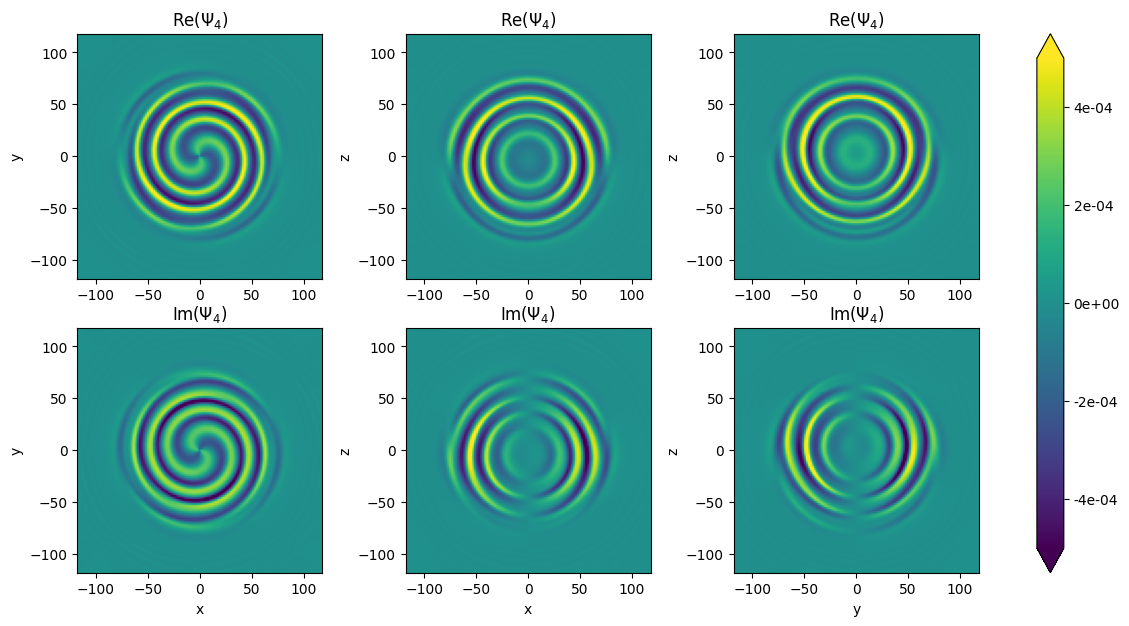

In [4]:
def plot_format(ax, title, xlabel, ylabel, colorbar=False):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

ix, iy, iz = 80, 80, 80
vmin, vmax = -5e-4, 5e-4

fig, axes = plt.subplots(2, 3, figsize=(15, 7))
im = axes[0,0].imshow(Psi4r[:,:,iz], vmin=vmin, vmax=vmax, extent=[fd.xmin, fd.xmax, fd.ymin, fd.ymax])
plot_format(axes[0,0], r'Re($\Psi_4$)', '', 'y')
axes[0,1].imshow(Psi4r[:,iy,:], vmin=vmin, vmax=vmax, extent=[fd.xmin, fd.xmax, fd.zmin, fd.zmax])
plot_format(axes[0,1], r'Re($\Psi_4$)', '', 'z')
axes[0,2].imshow(Psi4r[ix,:,:], vmin=vmin, vmax=vmax, extent=[fd.ymin, fd.ymax, fd.zmin, fd.zmax])
plot_format(axes[0,2], r'Re($\Psi_4$)', '', 'z', colorbar=True)

axes[1,0].imshow(Psi4i[:,:,iz], vmin=vmin, vmax=vmax, extent=[fd.xmin, fd.xmax, fd.ymin, fd.ymax])
plot_format(axes[1,0], r'Im($\Psi_4$)', 'x', 'y')
axes[1,1].imshow(Psi4i[:,iy,:], vmin=vmin, vmax=vmax, extent=[fd.xmin, fd.xmax, fd.zmin, fd.zmax])
plot_format(axes[1,1], r'Im($\Psi_4$)', 'x', 'z')
axes[1,2].imshow(Psi4i[ix,:,:], vmin=vmin, vmax=vmax, extent=[fd.ymin, fd.ymax, fd.zmin, fd.zmax])
plot_format(axes[1,2], r'Im($\Psi_4$)', 'y', 'z', colorbar=True)

fig.colorbar(im, ax=axes.ravel().tolist(), extend='both', format='%.0e')

## Get $\Psi_{4_{l,m}}$

All you need to do is provide the spacetime quantities to AurelCore and then call for 'Psi4_lm'. The calculations can be tuned by setting the 'tetrad', 'radius' (whose input format is a list so multiple radii can be computed), 'lmax', and the scipy interpolation method 'interp_method'. 

In practice you will probably want to calculate this at mutiple timesteps of your simulation. Therefore you should load the data of all these iterations and call 'aurel.over_time' to calculate 'Psi4_lm' for each timestep. This can be time consuming, so here we divide all the iterations into chunks where we gradually save the computed output.

In [5]:
radius = 90
lmax = 4
aurel_filename = param['simpath']+'/'+param['simname']+'/aurel_mp_Psi4.pkl'

In [6]:
allit = list(np.arange(0, 102400, 256))
chunksize = 8
it_in_chunks = [allit[i:i+chunksize] for i in range(0, len(allit), chunksize)]


verbose = True
for ichunk, it in enumerate(it_in_chunks):

    # Don't repead iterations already calculated
    if os.path.exists(aurel_filename):
        with open(aurel_filename, 'rb') as f:
            loaded_dict = pickle.load(f)
            it = [i for i in it if i not in loaded_dict['it']]

    if it != []:
        # Load data
        data = aurel.read_data(
            param, 
            vars = ['gammadown3', 'Kdown3', 'alpha', 'dtalpha', 'betaup3', 'dtbetaup3'],
            it = it,
            verbose = verbose
        )
    
        # Calculate
        data = aurel.over_time(
            data, fd, 
            vars=['Psi4_lm'],
            extract_radii=[radius], # It's a list so you can calculate multiple radii
            lmax = lmax,
            vacuum = True, # This simplifies the calculations
            interp_method = 'pchip', # Scipy interpolation method
            verbose = verbose
        )
    
        # Save data in file
        data_to_save = {key:item for key, item in data.items() if key in ['it', 't', 'Psi4_lm']}
        if os.path.exists(aurel_filename):
            # Load, merge and save
            with open(aurel_filename, 'r+b') as f:
                loaded_dict = pickle.load(f)
                for key in ['it', 't', 'Psi4_lm']:
                    loaded_dict[key] = np.append(loaded_dict[key], data_to_save[key])
                f.seek(0)
                pickle.dump(loaded_dict, f)
        else:
            # Create file and save data
            with open(aurel_filename, 'wb') as f:
                pickle.dump(data_to_save, f)
    
        verbose = False
        print('Chunk {} of {} done'.format(ichunk+1, len(it_in_chunks)), flush=True)

Reading iterations in /mnt/lustre/users/astro/rlm36/shortBBH/iterations.txt
Restarts to process: []
Nothing new to process. Consider running with skip_last=False to analyse the last restart (if it is not an active restart).
Loading existing content from /mnt/lustre/users/astro/rlm36/shortBBH/output-0001/shortBBH/content.txt...
Loaded 8 variables from cache.
 =========== Restart 1:
vars to get ['gammadown3', 'Kdown3', 'alpha', 'dtalpha', 'betaup3', 'dtbetaup3']:
Data read from split iterations: ['gxx', 'gyz', 'kyy', 'gyy', 'kxz', 'dtbetax', 'gxy', 'kyz', 'dtbetaz', 'dtbetay', 'kzz', 'gxz', 'gzz', 'betay', 'kxy', 'kxx', 'dtalpha', 'betaz', 'betax', 'alpha', 't']
Processing it = 97280


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Now processing remaining time steps sequentially


  0%|          | 0/3 [00:00<?, ?it/s]

Done!
Chunk 48 of 50 done


  0%|          | 0/7 [00:00<?, ?it/s]

Chunk 49 of 50 done


  0%|          | 0/7 [00:00<?, ?it/s]

Chunk 50 of 50 done


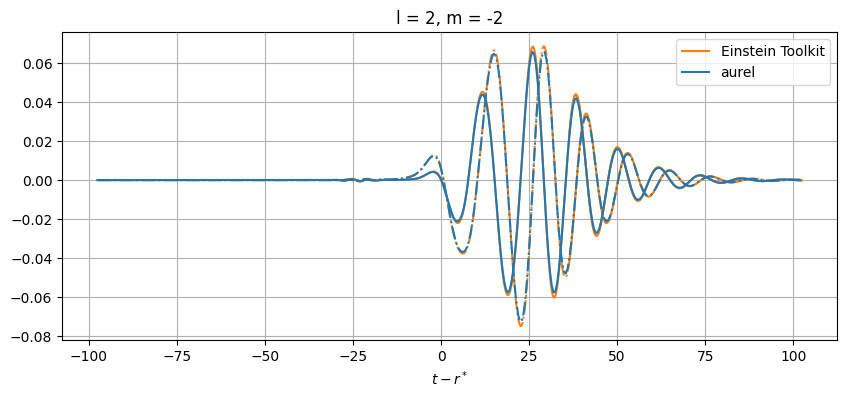

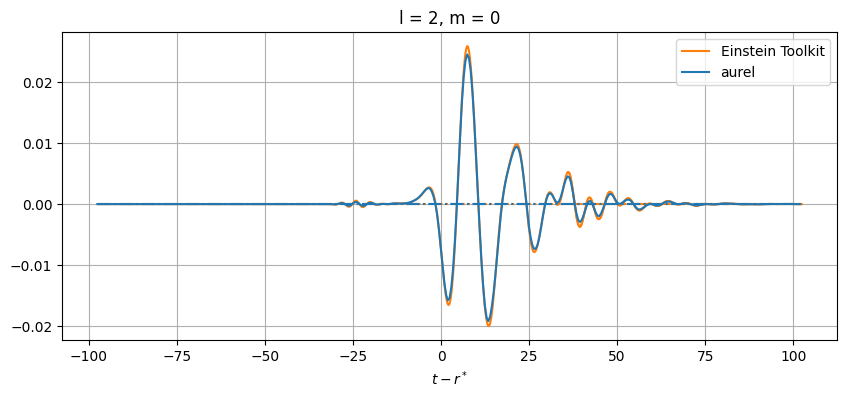

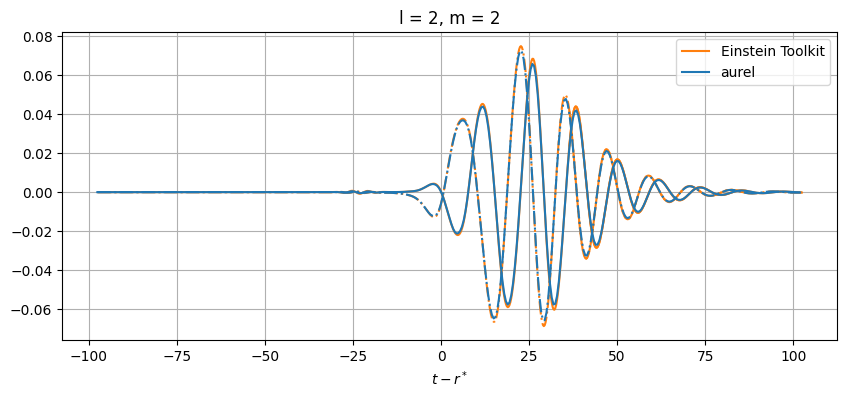

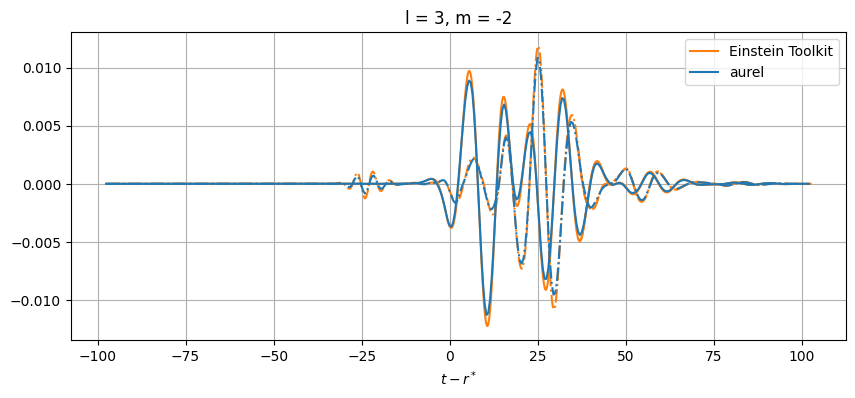

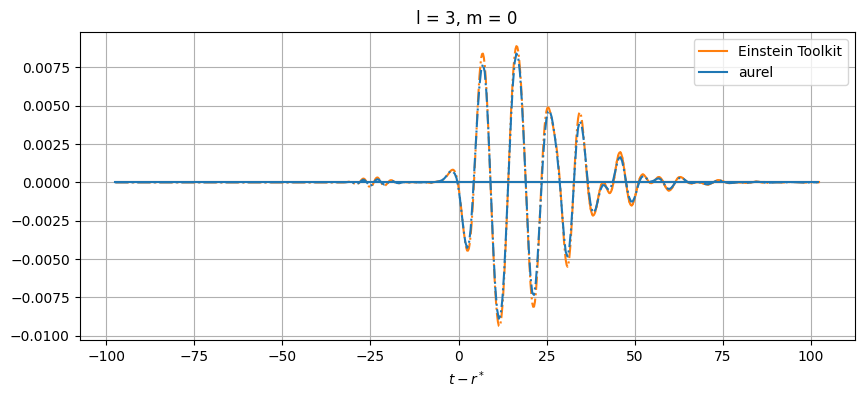

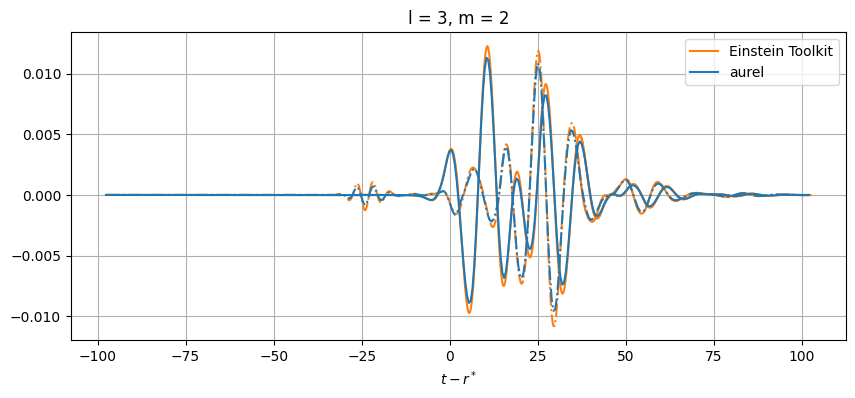

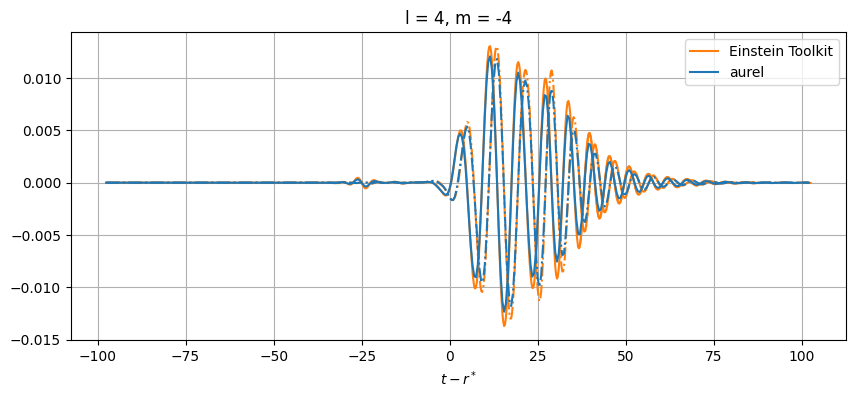

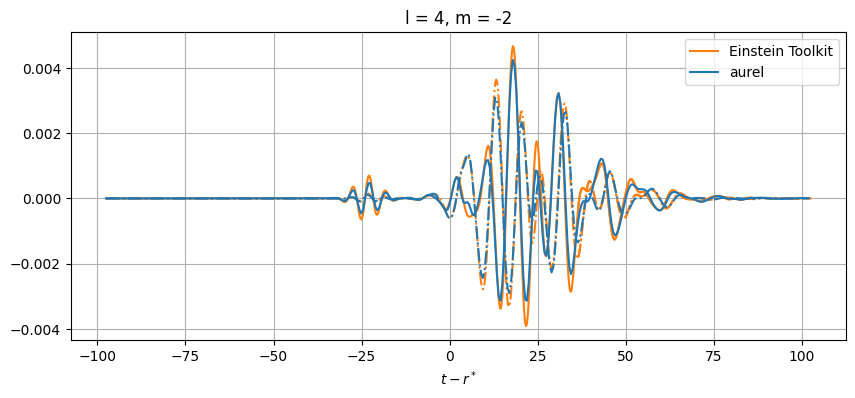

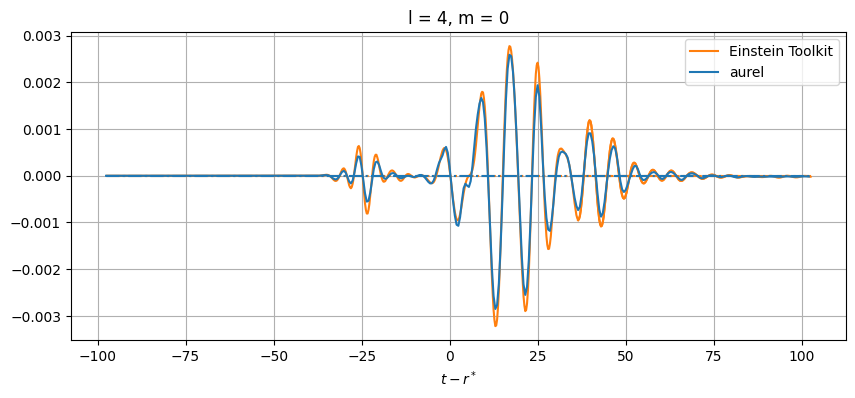

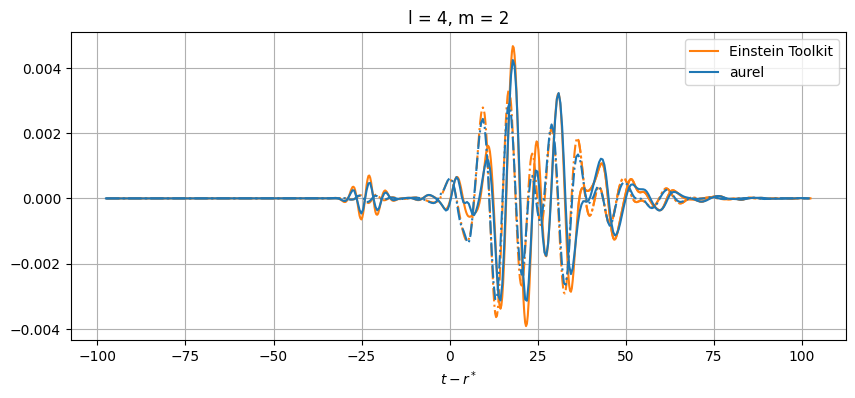

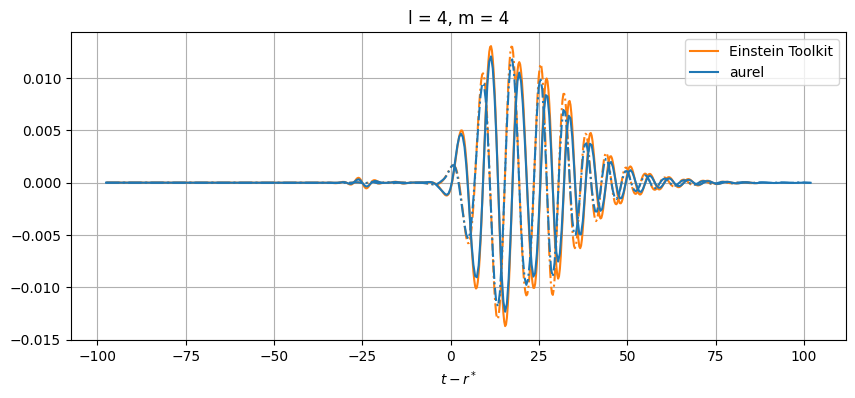

In [7]:
def time(t, r):
    M = 1
    return np.array(t) - r - 2*M*np.log(abs((r/(2*M)) - 1))

# Plot every mode
for l in range(2, lmax+1):
    for m in range(-l, l+1):

        # Skip modes = 0
        if (l,abs(m)) not in [(2,1), (3,3), (3,1), (4,3), (4,1)]:

            # formal plot
            plt.figure(figsize = (10,4))
            plt.title(f'l = {l}, m = {m}')

            # Einstein Toolkit output
            for restart in [0, 1]:
                ET_filename = (param['simpath']+'/'+param['simname']+'/output-{:04d}/'.format(restart)
                               +param['simname']+'/mp_Psi4_l{}_m{}_r{}.00.asc'.format(l,m,radius))
                if os.path.exists(ET_filename):
                    df = pd.read_csv(ET_filename, sep='\s+')
                    label = 'Einstein Toolkit' if restart == 0 else None
                
                    plt.plot(time(df[df.keys()[0]], radius), radius * df[df.keys()[1]], color='C1', label=label)
                    plt.plot(time(df[df.keys()[0]], radius), radius * df[df.keys()[2]], color='C1', linestyle='-.')
              
            # aurel output
            with open(aurel_filename, 'rb') as f:
                data = pickle.load(f)
            Psi4rlm = np.array([np.real(data['Psi4_lm'][iit][radius][l,m]) for iit in range(len(data['it']))])
            Psi4ilm = np.array([np.imag(data['Psi4_lm'][iit][radius][l,m]) for iit in range(len(data['it']))])
            plt.plot(time(data['t'], radius), radius * Psi4rlm, color='C0', label='aurel')
            plt.plot(time(data['t'], radius), radius * Psi4ilm, color='C0', linestyle='-.')
        
            # format plot
            plt.grid()
            plt.xlabel(r'$t - r^*$')
            plt.legend(bbox_to_anchor=(1,1))
            

While close, there are differences between the results. This can be from a number of numerical sources. In aurel, the wave zone approximation is not taken for the calculation of the Weyl tensor. Additionally different interpolation schemes are being used.